<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 37
# Student 1: Jiong Li | 1533312
# Student 2: Peter Elmers | 1734350
# Student 3: P.T.C.M. Tholhuijsen | 1237447

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

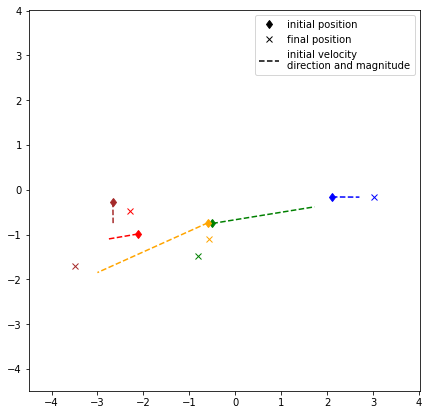

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
# Pick the best device
import torch

def try_device(device):
    # Try to put an array on given device. If successful, return device. Else, 'cpu'.
    x = torch.ones((1,))
    try:
        x.to(device)
        return device
    except:
        return 'cpu'

device = try_device('cuda')
if device == 'cpu':
    device = try_device('mps')

print(f'Device is set to {device}')

# Move all the little craps into torch things on the device
p_train, v_train, c_train = [torch.Tensor(vec).to(device=device) for vec in [positions_train, velocities_train, charges_train]]
p_valid, v_valid, c_valid = [torch.Tensor(vec).to(device=device) for vec in [positions_valid, velocities_valid, charges_valid]]
p_test, v_test, c_test = [torch.Tensor(vec).to(device=device) for vec in [positions_test, velocities_test, charges_test]]

Device is set to cuda


In [9]:
# Create a baseline: particle position = velocity * time + initial
def baseline_predict(p0, v0, time):
    '''
    Return a numpy array of predicted x, y position of each particle in p0.
    Given p0 starting locations, v0 starting velocities, and time to predict.
    Result is computed via linear projection: v0 * time + p0.
    Where p0 and v0 are both (N x 1 x 2 x P) tensors, for N simulations, P particles/sim
    '''
    return p0 + v0 * time


In [10]:
import torch.nn as nn

# Evaluate the baseline model (what metrics? r2? rms?)
def rms(p_pred, p_actual):
    '''
    Return the root mean squared distance between predicted locations and actual locations.
    Where p_pred and p_actual are both (N x T x 2 x P) tensors.
    '''
    mse = nn.MSELoss()
    return mse(p_pred, p_actual).sqrt().item()

def baseline_evaluate(p, v, time):
    '''
    Evaluate the baseline "model" at given time in {0, 0.5, 1, 1.5}.
    '''
    p_pred = baseline_predict(p[:, :1, :, :], v, time)
    idx = int(time / 0.5)
    p_actual = p[:, idx:idx+1, :, :]
    # Currently just rms, but we could add more evaluations
    return {'rms': rms(p_pred, p_actual)}

print('Baseline error should be 0:', baseline_evaluate(p_train, v_train, 0))

# Print some more metrics
for klass in ['train', 'valid', 'test']:
    p_klass, v_klass = locals()[f'p_{klass}'], locals()[f'v_{klass}']
    print(f'Error over time should increase ({klass}).')
    for t in [0.5, 1, 1.5]:
        print(f't = {t}', baseline_evaluate(p_train, v_train, t))

Baseline error should be 0: {'rms': 0.0}
Error over time should increase (train).
t = 0.5 {'rms': 0.2483280450105667}
t = 1 {'rms': 0.5178293585777283}
t = 1.5 {'rms': 0.7917788624763489}
Error over time should increase (valid).
t = 0.5 {'rms': 0.2483280450105667}
t = 1 {'rms': 0.5178293585777283}
t = 1.5 {'rms': 0.7917788624763489}
Error over time should increase (test).
t = 0.5 {'rms': 0.2483280450105667}
t = 1 {'rms': 0.5178293585777283}
t = 1.5 {'rms': 0.7917788624763489}


# Model Implementation

In [11]:
import torch.nn as nn
from tqdm import tqdm

Implementation like https://github.com/higgsfield/interaction_network_pytorch/blob/master/Interaction%20Network.ipynb

In [12]:
for i in zip(p_train, v_train, c_train):
    p = torch.transpose(i[0][0], 0, 1)
    v = torch.transpose(i[1][0], 0, 1)
    c = i[2]
   
    data = torch.hstack((p, v, c))
    print(data)
    print(data[:, 0:2])
    print(data[:, 2:4])
    # x_p, y_p, x_v, y_v, c
    break

tensor([[-1.9361, -0.2276, -0.7878,  0.0267, -1.0000],
        [ 3.6532, -2.7631,  1.5892, -0.4211,  1.0000],
        [-4.5496,  8.2998, -1.2906,  2.3834,  1.0000],
        [-3.0958, -3.0921, -1.9173, -0.5785,  1.0000],
        [ 0.1073, -2.8976,  0.6539, -0.5676, -1.0000]], device='cuda:0')
tensor([[-1.9361, -0.2276],
        [ 3.6532, -2.7631],
        [-4.5496,  8.2998],
        [-3.0958, -3.0921],
        [ 0.1073, -2.8976]], device='cuda:0')
tensor([[-0.7878,  0.0267],
        [ 1.5892, -0.4211],
        [-1.2906,  2.3834],
        [-1.9173, -0.5785],
        [ 0.6539, -0.5676]], device='cuda:0')


In [ ]:
# relation-centric neural network
class RelationModel(nn.Module):
    def __init__(self):
        super(RelationalModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear()
            nn.ReLU()
            nn.Linear()
            nn.ReLU()
            nn.Linear()
            nn.ReLU()
        )
    
    def forward(self, x):
        _, n_relations, input_size = x.size()
        x = x.view(-1, input_size)
        self.layers(x)
        x = x.view(5, n_relations, self.output_size)
        return x

In [13]:
# object-centric acceleration neural network
class AccelerationModel(nn.Module):
    def __init__(self):
        super(AccelerationModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(5, 25),
            nn.ReLU(),
            nn.Linear(25, 2),
        )
        
    def forward(self, x, delta_t):
        x = x.view(-1, 5)
        return self.layers(x)

In [14]:
# object-centric velocity neural network
class VelocityModel(nn.Module):
    def __init__(self):
        super(VelocityModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
        
    def forward(self, x, delta_t):
        x = x.view(-1, 4)
        return self.layers(x)

In [15]:
# object-centric position neural network
class PositionModel(nn.Module):
    def __init__(self):
        super(PositionModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
        
    def forward(self, x, delta_t):
        x = x.view(-1, 4)
        return self.layers(x)

In [ ]:
# object-centric neural network for accelleration, velocity and position
class ObjectModel(nn.Module):
    def __init__(self):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(),
            nn.ReLU(),
            nn.Linear(, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, x.size(2))
        return self.layers(x)

In [16]:
# interaction network
class InteractionNetwork(nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        
        self.acceleration_model = AccelerationModel()
        self.velocity_model = VelocityModel()
        self.position_model = PositionModel()
        
    def forward(self, x, delta_t):
        pred_accelleration = self.acceleration_model(x, delta_t)
        pred_velocity = self.velocity_model(torch.hstack((x[:, 2:4], pred_accelleration)), delta_t)
        pred_position = self.position_model(torch.hstack((x[:, 0:2], pred_velocity)), delta_t)
        return pred_position
    
interaction_network = InteractionNetwork()
interaction_network.to(device=device)

InteractionNetwork(
  (acceleration_model): AccelerationModel(
    (layers): Sequential(
      (0): Linear(in_features=5, out_features=25, bias=True)
      (1): ReLU()
      (2): Linear(in_features=25, out_features=2, bias=True)
    )
  )
  (velocity_model): VelocityModel(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (position_model): PositionModel(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [ ]:
optimizer = torch.optim.Adam(interaction_network.parameters(), lr=0.001)
criterion = nn.MSELoss()
criterion.to(device=device)

train_loss_graph, val_loss_graph = list(), list()
for epoch in tqdm(range(10)):
    train_loss, val_loss = list(), list()
    
    interaction_network = interaction_network.train()
    for i in zip(p_train, v_train, c_train):
        p = torch.transpose(i[0][0], 0, 1)
        v = torch.transpose(i[1][0], 0, 1)
        c = i[2]

        data = torch.hstack((p, v, c))
        # x_p, y_p, x_v, y_v, c
        
        optimizer.zero_grad()
        y_pred = interaction_network(data, 0.5)
        loss = criterion(y_pred, torch.transpose(i[0][1], 0, 1))
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item() / 5)
    
    train_loss_graph.append(sum(train_loss) / len(p_train))
    
    interaction_network = interaction_network.eval()
    for i in zip(p_valid, v_valid, c_valid):
        p = torch.transpose(i[0][0], 0, 1)
        v = torch.transpose(i[1][0], 0, 1)
        c = i[2]

        data = torch.hstack((p, v, c))
        # x_p, y_p, x_v, y_v, c
        
        optimizer.zero_grad()
        y_pred = interaction_network(data, 0.5)
        loss = criterion(y_pred, torch.transpose(i[0][1], 0, 1))
        
        val_loss.append(loss.item() / 5)
    
    val_loss_graph.append(sum(val_loss) / len(p_valid))
        
    print(f'Average loss: {train_loss_graph[-1]}')
    print(f'val loss: {val_loss_graph[-1]}')

 10%|████████▎                                                                          | 1/10 [00:26<04:02, 26.95s/it]

Average loss: 0.028501021920320106
val loss: 0.0055784383329097265


 20%|████████████████▌                                                                  | 2/10 [00:53<03:32, 26.51s/it]

Average loss: 0.005523326100378168
val loss: 0.005127389508800122


 30%|████████████████████████▉                                                          | 3/10 [01:18<03:01, 25.89s/it]

Average loss: 0.005132827079014086
val loss: 0.004941165196261133


 40%|█████████████████████████████████▏                                                 | 4/10 [01:44<02:35, 25.85s/it]

Average loss: 0.005012398006753348
val loss: 0.0048761450180725635


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:11<02:11, 26.30s/it]

Average loss: 0.004966070405560324
val loss: 0.004858449660887708


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:36<01:44, 26.11s/it]

Average loss: 0.004924934002562346
val loss: 0.004823001107620083


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:03<01:18, 26.23s/it]

Average loss: 0.004889257285125793
val loss: 0.004816908228181998


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_graph)
plt.title("training loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

In [ ]:
plt.plot(val_loss_graph)
plt.title("validation loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

In [19]:
class PINN(torch.nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Dense(features=25)
            nn.tanh()
            nn.Dense(features=25)
            nn.tanh()
            nn.Dense(features=25)
            nn.tanh()
            nn.Dense(features=25)
            nn.tanh()
            nn.Dense(features=25)
            nn.tanh()
            nn.Dense(features=25)
            nn.Linear(25)
        )
        self.delta_t = 0.001
        
    def calc_acc(self, x, c, t):
        torch.autograd.grad(x, c, t)
        
    def calc_pos(self, x, v, t):
        torch.autograd.grad()
        
        a = torch.sum([force for force in forces])
        v_new = v + a * self.delta_t
        new_pos = x + v_new * self.delta_t
        return new_x
        
    def forward(self, x):
        x = self.layers(x)
        return x
        

SyntaxError: invalid syntax (709580910.py, line 7)

In [11]:
acceleration[i][t] = sum([force for force in forces[i][t-delta_t]])
velocity[i][t] = velocity[i][t-delta_t] + acceleration[i][t] * delta_t
position[i][t] = position[i][t-delta_t] + velocity[i][t] * delta_t

In [14]:
positions_train[1000], velocities_train[1000], charges_train[1000]

(array([[[ 0.28550369, -2.83026035, -4.09011954,  5.86690925,
           3.34592891],
         [ 2.67076836, -0.24677496, -4.93502862,  3.56697064,
          -2.23848025]],
 
        [[ 0.32519777, -3.327417  , -4.72231886,  6.94438172,
           3.9414407 ],
         [ 3.06141083, -0.36164926, -5.89177367,  4.01903033,
          -2.57050795]],
 
        [[ 0.36478959, -3.83607425, -5.36116502,  8.03212461,
           4.54493177],
         [ 3.4649563 , -0.47540496, -6.85987972,  4.4777738 ,
          -2.91188004]],
 
        [[ 0.40424833, -4.35349455, -6.00493702,  9.12768574,
           5.15442658],
         [ 3.87835058, -0.58833091, -7.83660568,  4.94159813,
          -3.26039165]]]),
 array([[[ 0.07945439, -0.98033438, -1.25614375,  2.14243246,
           1.18123603],
         [ 0.76562579, -0.23114694, -1.89962386,  0.89597175,
          -0.65271654]]]),
 array([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]]))

In [23]:
positions_train[998].shape

(4, 2, 5)

In [15]:
# The position arrays are shaped as
# [simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

# The initial velocity arrays are shaped as
# [simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

# The charge arrays are shaped as [simulation id, particle id, 1]

positions_train[1000].shape, velocities_train[1000].shape, charges_train[1000].shape

((4, 2, 5), (1, 2, 5), (5, 1))

# Model Training

In [12]:
#todo

# Evaluation

In [13]:
#TODO:
# The amount of training samples should vary from 100 to 10000, and the
# prediction horizons are t = 0.5, t = 1 and t = 1.5. For each training set
# size/time horizon combination, compare to a simple linear baseline where
# xti = x0i + v0i ·t

In [ ]:
# TODO
# Come up with and execute one additional experiment that provides an interesting insight in your method
# possible idea: interpolation, i.e. given t = 1.5 and t = 0.5, where is it at t = 1?
